# **Traffic Flow Analysis**

**In cities, growing traffic congestion causes:**

- longer commute times.

- Increased anger among drivers.


**In this Project,**

We will use the YOLO (You Only Look Once) object detection model to analyze road traffic, density estimator, and vehicle counting.


**Objectives**

Count the number of vehicles on the road.

Detect traffic density in real-time to understand congestion levels.

Track vehicle and movement to identify patterns.


In [ ]:
!pip install opencv-python
!pip install tqdm --upgrade
!pip install ultralytics

### Import libraries

In [ ]:
import os
HOME = os.getcwd()
print(HOME)
!nvidia-smi

import random

from tqdm.notebook import tqdm

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO, solutions
from IPython.display import display, Image,Video

import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/78.2 GB disk)


### Exploratory Data Analysis (EDA)

Preprocessing

  - Normalization, and frame extraction.
  
Data Visualization
   - Visualize a few frames from the video to understand the content and distribution of objects within the frames.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0UbPioorAEcTJR9Qvyyf")
project = rf.workspace("farzad").project("vehicle_detection_yolov8")
version = project.version(3)
dataset = version.download("yolov8")

# When you run this code open data.yaml and replace the content with this :
'''
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Vehicle']

roboflow:
  workspace: farzad
  project: vehicle_detection_yolov8
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3

'''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.87, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Vehicle_Detection_YOLOv8-3 in yolov8:: 100%|██████████| 1261/1261 [00:00<00:00, 5711.63it/s]


"\ntrain: ../train/images\nval: ../valid/images\ntest: ../test/images\n\nnc: 1\nnames: ['Vehicle']\n\nroboflow:\n  workspace: farzad\n  project: vehicle_detection_yolov8\n  version: 3\n  license: CC BY 4.0\n  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3\n\n"

In [ ]:

train_images_path = os.path.join('/content/Vehicle_Detection_YOLOv8-3', 'train', 'images')
valid_images_path = os.path.join('/content/Vehicle_Detection_YOLOv8-3', 'valid', 'images')

num_train_images = 0
num_valid_images = 0

train_image_sizes = set()
valid_image_sizes = set()

for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


Text(0.5, 0.98, 'Sample Images from Training Dataset')

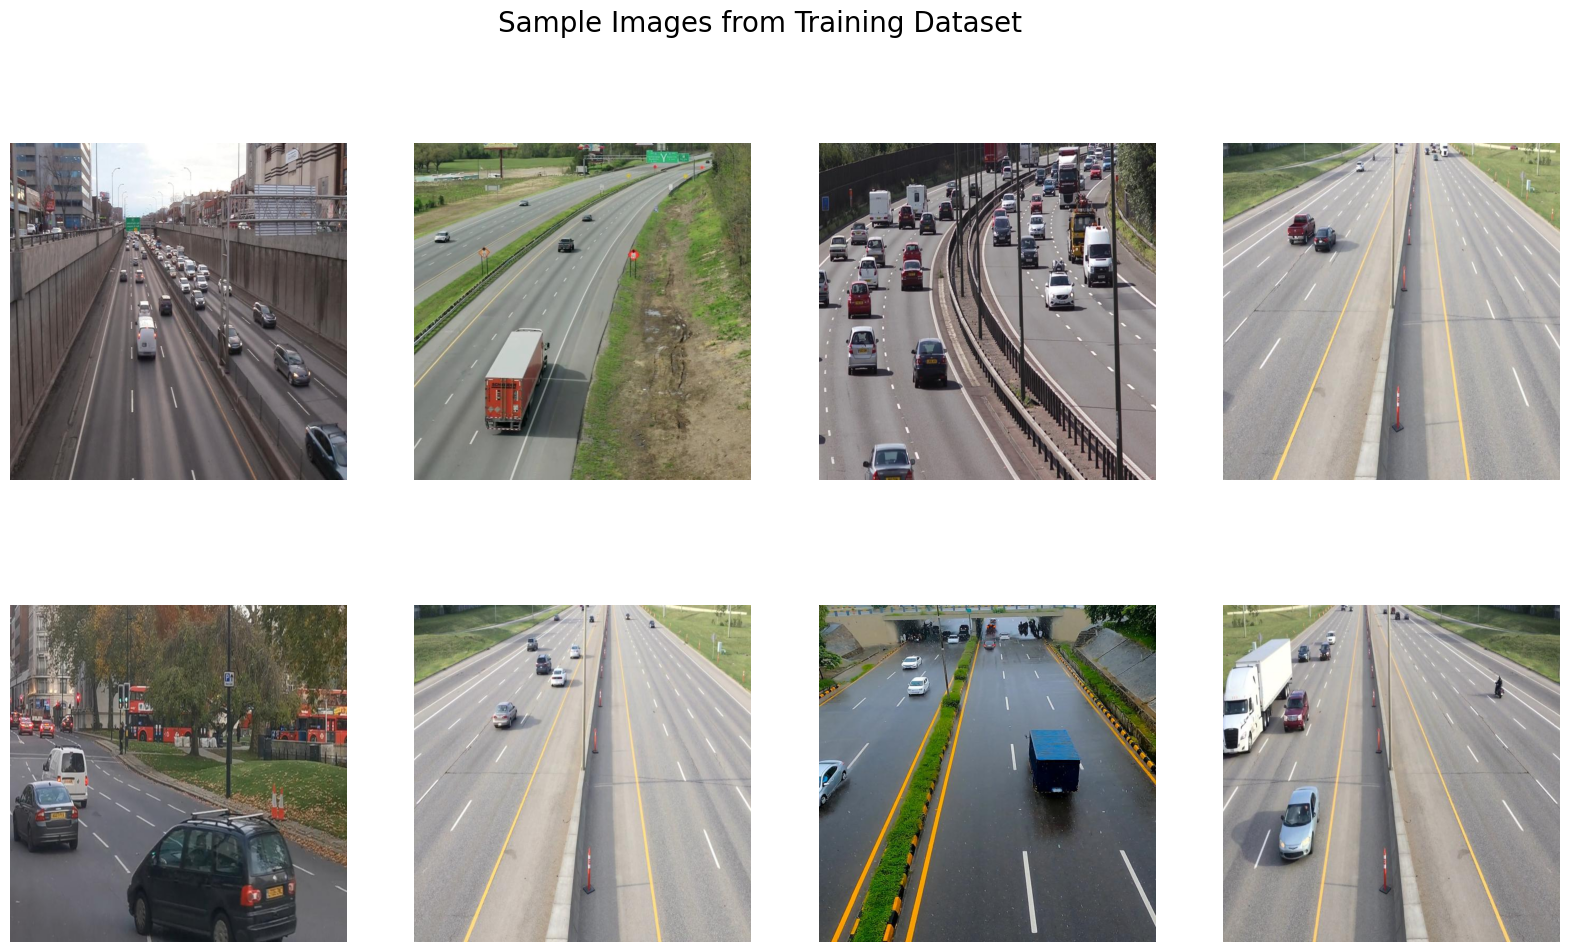

In [ ]:
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

fig, axes = plt.subplots(2, 4, figsize=(20, 11))

for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)

### Model Development and Training

YOLO Model Implementation
- Train the YOLO Model on the Training Dataset

In [ ]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 441MB/s]


In [ ]:
results = model.train(
    data='/content/Vehicle_Detection_YOLOv8-3/data.yaml',
    epochs=75,
    patience=15,
    imgsz=640,
    batch=8,
    optimizer='Adam',
    lr0=0.001,
    dropout=0.1,
    seed=0,)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Vehicle_Detection_YOLOv8-3/data.yaml, epochs=75, time=None, patience=15, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/Vehicle_Detection_YOLOv8-3/train/labels.cache... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/Vehicle_Detection_YOLOv8-3/valid/labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      2.37G      1.206      0.929      1.028         88        640: 100%|██████████| 67/67 [00:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

                   all         90        937      0.862      0.874      0.934      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      2.24G      1.135      0.748      1.005        136        640: 100%|██████████| 67/67 [00:20<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

                   all         90        937      0.788      0.814      0.852      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75       2.3G      1.105      0.687      1.006        201        640: 100%|██████████| 67/67 [00:14<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]

                   all         90        937      0.843      0.896      0.925      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      2.25G      1.068      0.665     0.9932        116        640: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]

                   all         90        937      0.895      0.892       0.96      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      2.27G      1.066     0.6512     0.9976        109        640: 100%|██████████| 67/67 [00:17<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]

                   all         90        937      0.884      0.893      0.952      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      2.28G       1.05     0.6062       0.98         98        640: 100%|██████████| 67/67 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

                   all         90        937      0.889      0.901      0.957      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      2.24G      1.036     0.5968     0.9817        102        640: 100%|██████████| 67/67 [00:12<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]

                   all         90        937      0.888      0.891      0.946      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      2.26G      1.058     0.6045     0.9917        115        640: 100%|██████████| 67/67 [00:15<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]

                   all         90        937      0.895      0.904       0.96      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      2.25G      1.023     0.5809     0.9709        133        640: 100%|██████████| 67/67 [00:16<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all         90        937      0.902      0.916      0.957      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      2.27G      1.012     0.5758     0.9678        133        640: 100%|██████████| 67/67 [00:16<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]

                   all         90        937      0.888      0.899       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      2.26G     0.9937     0.5781     0.9622        146        640: 100%|██████████| 67/67 [00:13<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]

                   all         90        937      0.927      0.893      0.966      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      2.35G     0.9943     0.5605     0.9609         86        640: 100%|██████████| 67/67 [00:13<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]

                   all         90        937      0.901      0.919      0.966       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      2.27G     0.9777     0.5497     0.9674         88        640: 100%|██████████| 67/67 [00:15<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all         90        937      0.914      0.923       0.97      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      2.26G     0.9921     0.5417     0.9625        170        640: 100%|██████████| 67/67 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]

                   all         90        937      0.918      0.922      0.964      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      2.25G     0.9814     0.5463     0.9578        123        640: 100%|██████████| 67/67 [00:18<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]

                   all         90        937      0.898      0.914       0.97      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      2.28G     0.9736      0.563     0.9533        206        640: 100%|██████████| 67/67 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

                   all         90        937      0.918      0.901      0.962      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      2.27G     0.9759      0.547     0.9486        144        640: 100%|██████████| 67/67 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.96it/s]

                   all         90        937      0.911      0.903      0.967       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      2.26G     0.9602     0.5291     0.9472        176        640: 100%|██████████| 67/67 [00:15<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

                   all         90        937      0.913      0.911      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      2.26G     0.9767     0.5294     0.9521        145        640: 100%|██████████| 67/67 [00:16<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.04it/s]

                   all         90        937      0.877      0.932      0.964      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      2.25G     0.9609      0.528      0.947        165        640: 100%|██████████| 67/67 [00:14<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

                   all         90        937      0.914      0.933      0.974      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      2.25G     0.9599     0.5327     0.9548        204        640: 100%|██████████| 67/67 [00:12<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]

                   all         90        937      0.936      0.899      0.974      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      2.34G      0.952     0.5109     0.9481        136        640: 100%|██████████| 67/67 [00:14<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

                   all         90        937      0.891      0.936      0.969      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      2.23G     0.9393     0.5259     0.9458         98        640: 100%|██████████| 67/67 [00:16<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]

                   all         90        937      0.923      0.902       0.96      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      2.18G     0.9316     0.5102     0.9372         86        640: 100%|██████████| 67/67 [00:15<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all         90        937      0.916      0.923      0.969      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      2.26G     0.9227     0.5016     0.9373         99        640: 100%|██████████| 67/67 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]

                   all         90        937       0.93      0.921      0.977      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      2.23G     0.9183     0.4945     0.9359        158        640: 100%|██████████| 67/67 [00:13<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.06it/s]

                   all         90        937      0.905      0.921      0.971      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      2.26G     0.9219     0.4985     0.9472         67        640: 100%|██████████| 67/67 [00:18<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

                   all         90        937      0.928      0.895      0.965       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      2.38G     0.9269     0.5053     0.9324        130        640: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]

                   all         90        937      0.904      0.943      0.969      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      2.37G     0.9063     0.4819     0.9364        128        640: 100%|██████████| 67/67 [00:15<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]

                   all         90        937      0.906      0.919      0.972      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      2.28G       0.91      0.491     0.9261        152        640: 100%|██████████| 67/67 [00:12<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


                   all         90        937      0.914       0.91      0.972      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      2.24G     0.9002     0.4827     0.9352        155        640: 100%|██████████| 67/67 [00:14<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all         90        937      0.922      0.916       0.97       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      2.35G     0.8982     0.4779     0.9287        120        640: 100%|██████████| 67/67 [00:16<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]

                   all         90        937      0.906      0.925       0.97      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      2.24G     0.8964     0.4627     0.9259        125        640: 100%|██████████| 67/67 [00:15<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]

                   all         90        937      0.919      0.924      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      2.27G     0.8957     0.4683     0.9351         86        640: 100%|██████████| 67/67 [00:12<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

                   all         90        937      0.877      0.936      0.968      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      2.24G     0.8927     0.4639     0.9244        125        640: 100%|██████████| 67/67 [00:14<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]

                   all         90        937      0.908       0.94      0.975      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      2.25G     0.8998     0.4724     0.9308         66        640: 100%|██████████| 67/67 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]

                   all         90        937      0.929       0.91       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      2.26G     0.8861     0.4679     0.9246         93        640: 100%|██████████| 67/67 [00:16<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

                   all         90        937      0.904      0.936      0.969      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      2.27G     0.8696     0.4456     0.9199        144        640: 100%|██████████| 67/67 [00:13<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


                   all         90        937      0.917      0.925      0.974      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      2.23G     0.8748     0.4669     0.9167        152        640: 100%|██████████| 67/67 [00:13<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]

                   all         90        937      0.919      0.938      0.974      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      2.25G     0.8572     0.4636     0.9171         86        640: 100%|██████████| 67/67 [00:20<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

                   all         90        937      0.917       0.92      0.972      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      2.26G     0.8499     0.4514     0.9137        165        640: 100%|██████████| 67/67 [00:16<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.12it/s]

                   all         90        937       0.94      0.897      0.973       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      2.27G     0.8444     0.4386     0.9112        102        640: 100%|██████████| 67/67 [00:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

                   all         90        937      0.923      0.919       0.97      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      2.24G     0.8571     0.4478     0.9125        119        640: 100%|██████████| 67/67 [00:12<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

                   all         90        937      0.894      0.938      0.967      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      2.32G     0.8325     0.4425     0.9084        132        640: 100%|██████████| 67/67 [00:12<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]

                   all         90        937      0.916       0.93       0.97      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      2.25G     0.8457     0.4358     0.9105         55        640: 100%|██████████| 67/67 [00:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all         90        937      0.919      0.922      0.971      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      2.33G     0.8433     0.4337     0.9155         93        640: 100%|██████████| 67/67 [00:15<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.96it/s]

                   all         90        937      0.905      0.938      0.968      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      2.24G     0.8244     0.4294     0.9098         97        640: 100%|██████████| 67/67 [00:14<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

                   all         90        937      0.904      0.951      0.964       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      2.34G     0.8242     0.4285     0.9085         95        640: 100%|██████████| 67/67 [00:12<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

                   all         90        937      0.884      0.952      0.968      0.741
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 33, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



48 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


                   all         90        937      0.918      0.924      0.973      0.743
Speed: 0.8ms preprocess, 6.5ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/train4


### Model Evaluation
Evaluate the Performance of the YOLO Model
- By Use metrics such as mAP (mean Average Precision), precision, and recall

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Tuwaiq/results.csv") #result.csv from the detect/train2
df.columns = df.columns.str.strip()


def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='#141140', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='orangered', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

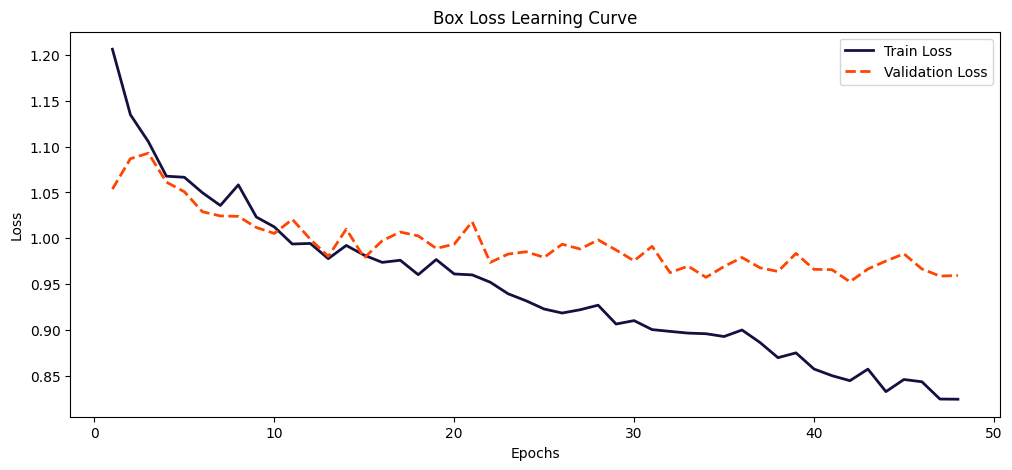

In [ ]:
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss Learning Curve')

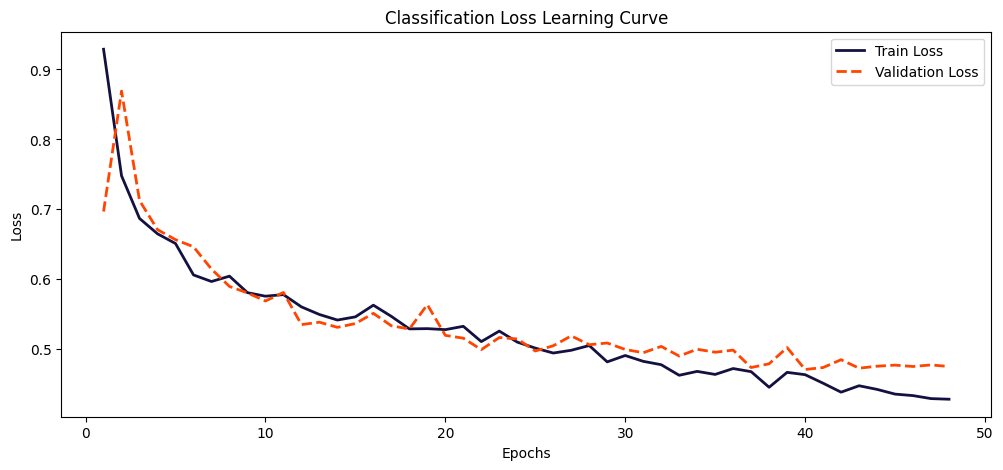

In [ ]:
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')

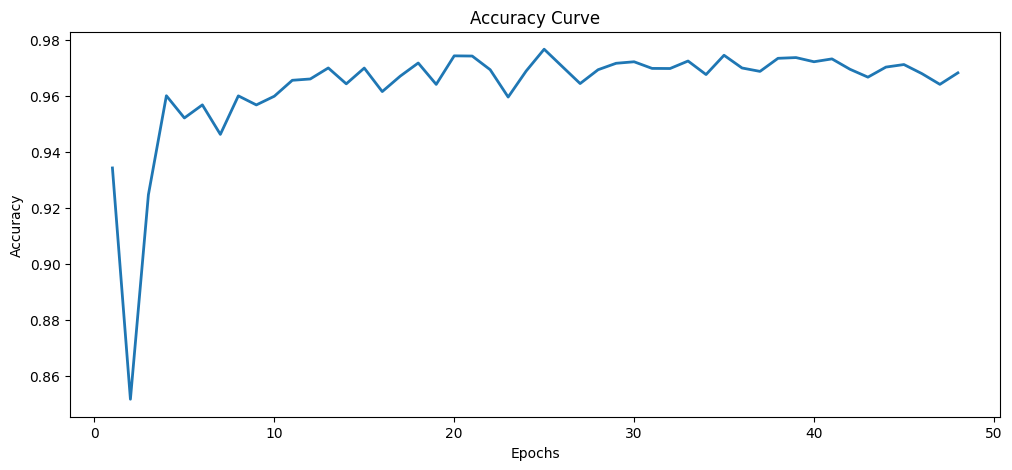

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='epoch', y='metrics/mAP50(B)', linewidth=2)
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

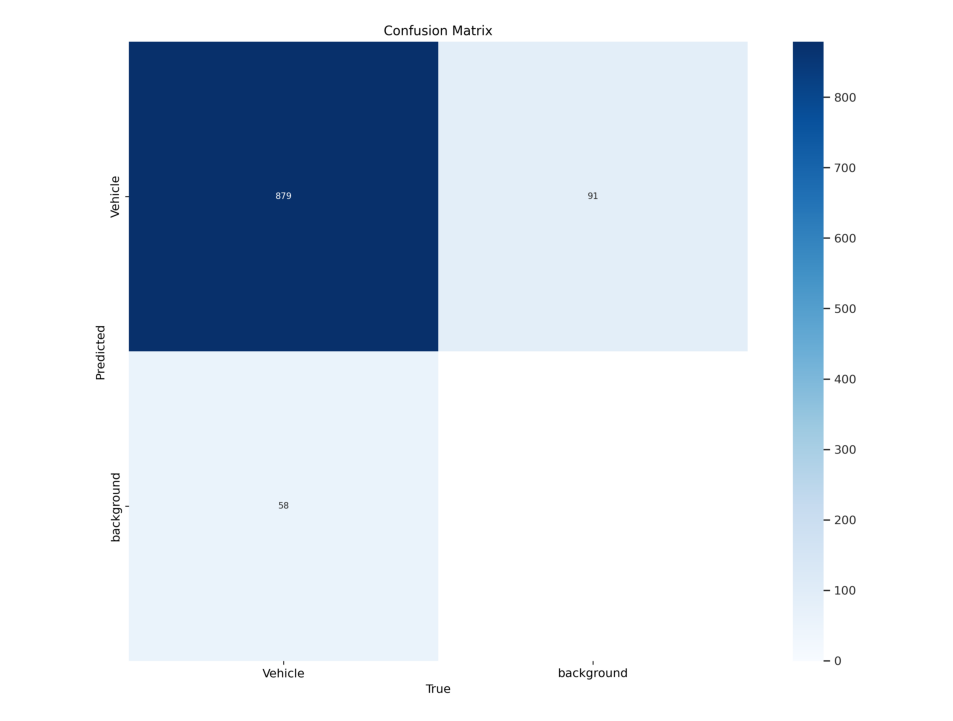

In [ ]:
cm_img = cv2.imread('/content/drive/MyDrive/Tuwaiq/confusion_matrix.png')

cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10), dpi=120)
plt.imshow(cm_img)
plt.axis('off')
plt.show()

## **Model Evaluation**

In [ ]:
best_model = YOLO('/content/drive/MyDrive/Tuwaiq/weights/best.pt')
metrics = best_model.val(split='val')
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])
metrics_df.round(3)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]
val: Scanning /content/Vehicle_Detection_YOLOv8-3/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 1807.11it/s]

val: New cache created: /content/Vehicle_Detection_YOLOv8-3/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


                   all         90        937      0.918      0.924      0.973      0.745
Speed: 6.0ms preprocess, 18.9ms inference, 0.0ms loss, 11.8ms postprocess per image
Results saved to runs/detect/val2


Metric Value
metrics/precision(B)         0.918
metrics/recall(B)            0.924
metrics/mAP50(B)             0.973
metrics/mAP50-95(B)          0.745
fitness                      0.768


image 1/1 /content/test.jpg: 384x640 27 Vehicles, 76.1ms
Speed: 4.1ms preprocess, 76.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


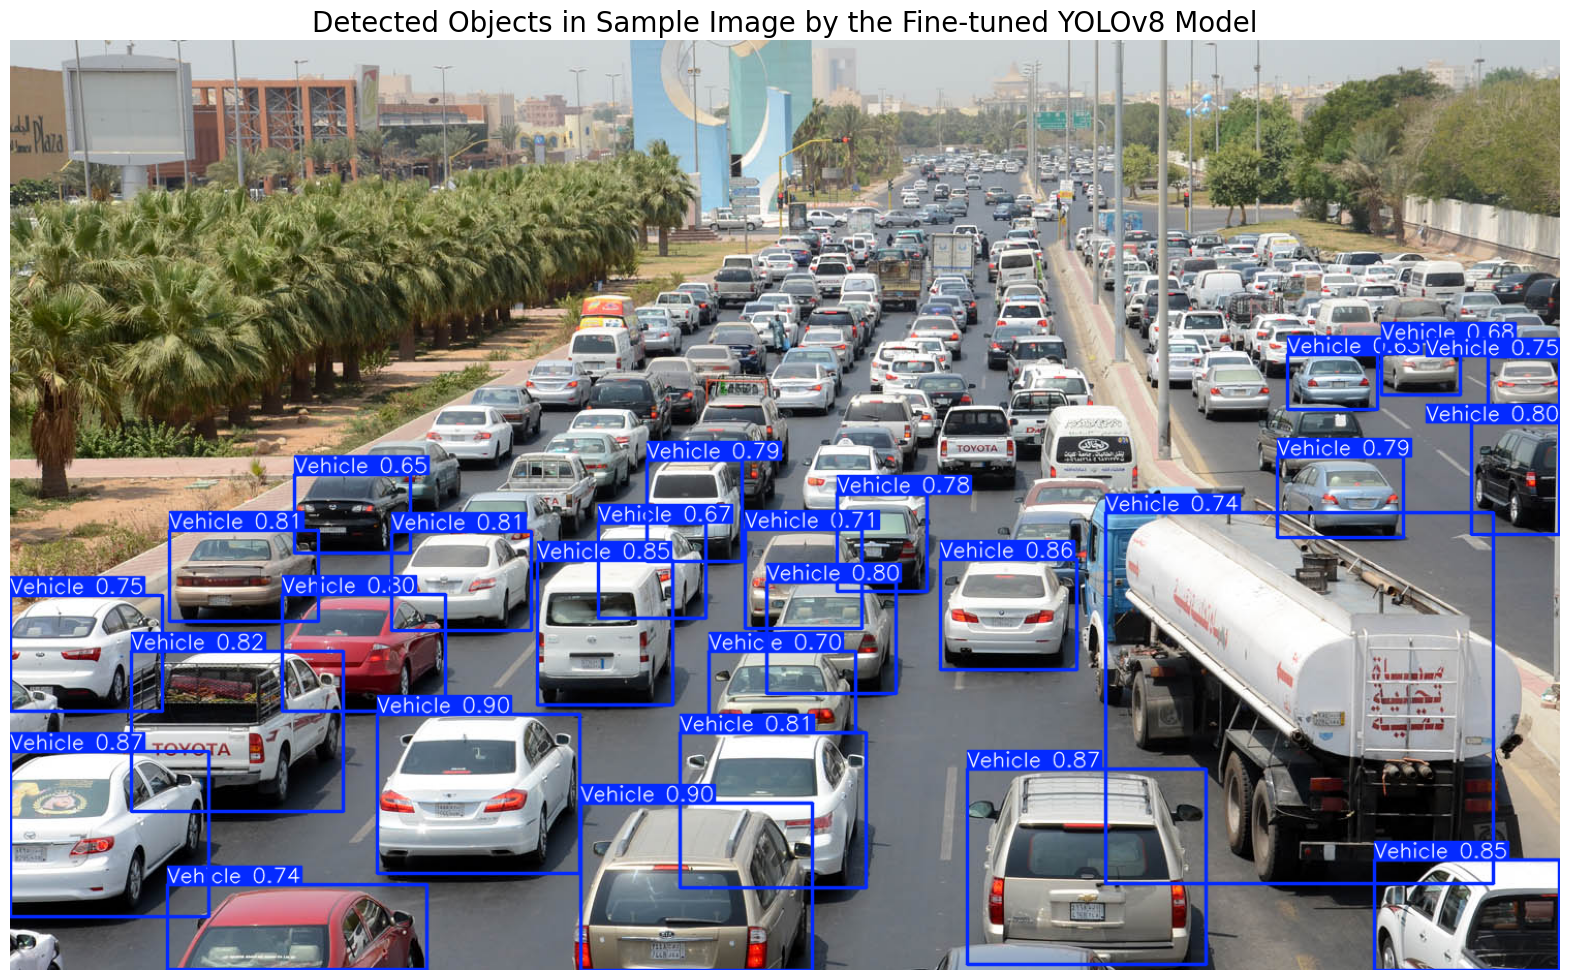

In [ ]:
results = best_model.predict(source='/content/test.jpg', imgsz=640, conf=0.6)

sample_image = results[0].plot(line_width=2)

sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,15))
plt.imshow(sample_image)
plt.title('Detected Objects in Sample Image by the Fine-tuned YOLOv8 Model', fontsize=20)
plt.axis('off')
plt.show()

# Deep Solution

In [ ]:
# vid = cv2.VideoCapture("/content/3exits.mp4")
# w, h, fps = (int(vid.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
# print("Video's height: ",h)
# print("Video's width: ",w)
# print("Video's FPS: ",fps)
# video_writer = cv2.VideoWriter("Yolo_Weekly_Project.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps,(w,h))

### Video #1: 3 Exits

In [ ]:
vertices1 = np.array([
    (760, 717),
    (1125, 717),
    (1175, 500),
    (1275, 400),
    (1100, 325),
    (1000, 400),
    (875, 500),
], dtype=np.int32)

vertices2 = np.array([
    (475, 717),
    (750, 717),
    (750, 625),
    (735, 500),
    (710, 400),
    (680, 300),
    (625, 200),
    (535, 100),
    (480, 25),
    (425, 25),
    (460, 100),
    (515, 200),
    (525, 300),
    (535, 400),
], dtype=np.int32)

vertices3 = np.array([
    (450, 717),
    (0, 717),
    (0, 600),
    (75, 500),
    (160, 400),
    (275, 250),
    (325, 150),
    (350, 25),
    (424, 25),
    (480, 150),
    (515, 250),
    (510, 500),
], dtype=np.int32)

cap = cv2.VideoCapture("/content/3exits.mp4")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("3 exits Mini porject output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

def is_point_in_polygon(point, vertices):
    result = cv2.pointPolygonTest(vertices, point, False)
    return result >= 0

while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    detection_frame = frame.copy()

    results = model.predict(detection_frame)
    processed_frame = results[0].plot(line_width=1)

    cv2.polylines(processed_frame, [vertices1], isClosed=True, color=(0, 0, 255), thickness=2)
    cv2.polylines(processed_frame, [vertices2], isClosed=True, color=(255, 0, 0), thickness=2)
    cv2.polylines(processed_frame, [vertices3], isClosed=True, color=(0, 0, 0), thickness=2)

    count1, count2, count3 = 0, 0, 0

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        centroid = ((x1 + x2) // 2, (y1 + y2) // 2)

        if is_point_in_polygon(centroid, vertices1):
            count1 += 1
        elif is_point_in_polygon(centroid, vertices2):
            count2 += 1
        elif is_point_in_polygon(centroid, vertices3):
            count3 += 1



    text1 = f"ROI 1 Vehicles: {count1} | Traffic: {'Heavy' if count1 > 2 else 'Light'}"
    text2 = f"ROI 2 Vehicles: {count2} | Traffic: {'Heavy' if count2 > 5 else 'Light'}"
    text3 = f"ROI 3 Vehicles: {count3} | Traffic: {'Heavy' if count3 > 5 else 'Light'}"

    font_scale = 0.6
    font_thickness = 1
    text_color = (255, 255, 255)
    background_color = (0, 0, 0)

    def draw_text_with_background(frame, text, position):
        (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        cv2.rectangle(frame, (position[0], position[1] - text_h - baseline),
                      (position[0] + text_w, position[1] + baseline), background_color, -1)
        cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness, cv2.LINE_AA)

    draw_text_with_background(processed_frame, text1, (w - 400, 50))
    draw_text_with_background(processed_frame, text2, (w - 400, 100))
    draw_text_with_background(processed_frame, text3, (w - 400, 150))

    out.write(processed_frame)

cap.release()
out.release()


### Video #2: drive at night

In [ ]:
vertices1 = np.array([
    (240, 375),
    (300, 500),
    (175, 717),
    (1275, 717),
    (1175, 600),
    (750, 400),
    (550, 335),
    (450, 315),
], dtype=np.int32)

cap = cv2.VideoCapture("/content/NightDrive.mp4")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("Night Drive Mini porject output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

def is_point_in_polygon(point, vertices):
    result = cv2.pointPolygonTest(vertices, point, False)
    return result >= 0

while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    detection_frame = frame.copy()

    results = model.predict(detection_frame)
    processed_frame = results[0].plot(line_width=1)

    cv2.polylines(processed_frame, [vertices1], isClosed=True, color=(0, 0, 255), thickness=2)


    count1 = 0

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        centroid = ((x1 + x2) // 2, (y1 + y2) // 2)

        if is_point_in_polygon(centroid, vertices1):
            count1 += 1


    text1 = f"ROI 1 Vehicles: {count1} | Traffic: {'Heavy' if count1 > 5 else 'Light'}"


    font_scale = 0.6
    font_thickness = 1
    text_color = (255, 255, 255)
    background_color = (0, 0, 0)

    def draw_text_with_background(frame, text, position):
        (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        cv2.rectangle(frame, (position[0], position[1] - text_h - baseline),
                      (position[0] + text_w, position[1] + baseline), background_color, -1)
        cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness, cv2.LINE_AA)

    draw_text_with_background(processed_frame, text1, (w - 400, 50))

    out.write(processed_frame)

cap.release()
out.release()


### to Display one frame

In [ ]:
video = cv2.VideoCapture('/content/Yolo_Weekly_Project.mp4')

fps = video.get(cv2.CAP_PROP_FPS)

min = 0
sec = 0.1
frame_id = int(fps*(min*60 + sec))
print('frame id =',frame_id)

video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = video.read()

t_msec = 1000*(min*60 + sec)
video.set(cv2.CAP_PROP_POS_MSEC, t_msec)
ret, frame = video.read()

cv2.imwrite('myframe.png', frame)

# https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359